# Huggingface Dataset

In [1]:
from datasets import list_datasets

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/tmp/ipykernel_53/2416910594.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 70080 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

## huggingface hub からデータセット読み込み

In [4]:
emotions = load_dataset("dair-ai/emotion")
print(emotions)

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 69804.43 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [12]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


## ローカルでのデータセット読み込み

In [13]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-10-15 05:38:56--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.172.52.61, 18.172.52.38, 18.172.52.121, ...
Connecting to huggingface.co (huggingface.co)|18.172.52.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  3.91MB/s    in 0.4s    

2023-10-15 05:38:57 (3.91 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [14]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [16]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 129.12it/s]
Generating train split: 16000 examples [00:00, 562644.53 examples/s]


In [17]:
emotions_local

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

### 直接url指定

In [20]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])

In [21]:
emotions_remote

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

# データセットからDataFrameへ

In [23]:
import pandas as pd

emotions.set_format(type="pandas") # DatasetDict to DataFrame
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [24]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

In [28]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [34]:
print(type(df['label_name']))
print(type(df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


## 各クラスの分布を調査

In [36]:
import matplotlib.pyplot as plt

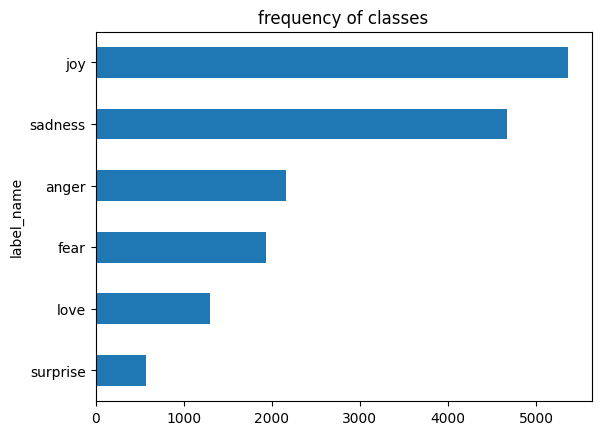

In [39]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

# 今回は値がばらばらのまま進めるが、本来はクラスを均一にするのが好ましい。
# 詳しくは https://oreil.ly/5XBhb を確認するとよい。
# 自分的にはこっちの方がわかりやすそう。 https://learn.microsoft.com/en-us/training/modules/explore-analyze-data-with-python/?WT.mc_id=cloudskillschallenge_3F886A40-54D6-42DA-BDD5-BA0B210A04B9 

## ツイートの長さを推定

Transformerには最大コンテキストサイズがあるため、あらかじめツイートごとの単語数の分布をみて、感情毎のツイートの長さを大まかに推定する。

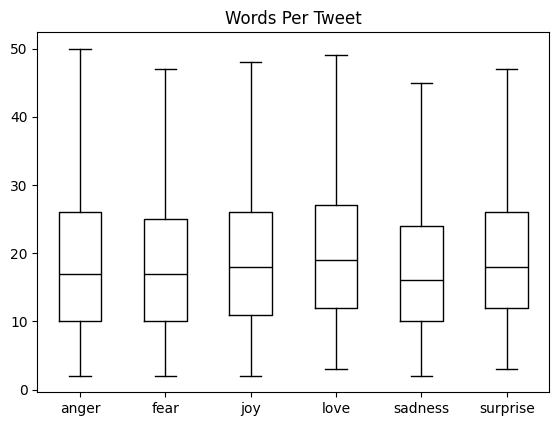

In [42]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
# df.str ... Seriesの各要素に対して文字列操作を行う
# .split() ... デフォルトではスペース区切りとなるため、例えば"Hello World".split() なら ["Hello", "World"] となる。
# .apply() ... Seriesの各要素に()で指定された関数の処理を行う。len は組み込み関数で、実質 lambda str: len(str) を行っているようなもの

df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

## 後処理
データ分析を終えたらDataFrameを使う必要がないので、データセットの出力形式をリセットしておく。

In [43]:
emotions.reset_format()

In [44]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})